# SGD Optimizer

#### Import

In [1]:
import time

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from tensorflow.keras.utils import to_categorical

from mlxtend.plotting import plot_confusion_matrix

#for reproducibility, we set random seeds here
#Jupyter can sometimes assign seed value only in the cell that the random seed is called
#you can change this rseed value so the entire notebook changes seed values
rseed = 42

np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

## Load Data

We load the data created in the 01 - Data section of this report.

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

Now we perform the processing for our categorical y's

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

## Training

Below we define two functions that create a binary and a categorical Deep Neural Net. 

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe X_train and creates a binary classifer neural network 
    with single node sigmoid output
    
    X_train = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers 
    for i in hidden_nodes:
        #we use 'relu' as good, safe default for our neural nets
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model



def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', metrics = ['accuracy']):
    '''
    Function that takes dataframe X_train and creates a multiclass classifer neural network 
    with softmax output layers equal to the number of classes passed
    
    X_train = dataframe or array 
    num_classes = int, number of classes in the dataset
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with num_classes final output
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    #there are some issues with softmax, namely if classes in the train and test datasets are different
    #however we constructed our dataset in such a manner that this issue should not take place.
    nn_model.add(Dense(num_classes, activation = 'softmax'))
    
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

Since we will be assessing how our optimizers work on different learning rates for more meaningful comparison, we create an array of epsilons below.

In [5]:
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

In [6]:
epsilons

array([0.1   , 0.01  , 0.001 , 0.0001])

The code below was created to iterate over each value of epsilon created above, creating a binary and multiclass DNN for each of our optimizers. However, this caused a memory issue as too many large variables were being stored, so some of the sections are commented out / not optimal. But the code runs perfectly fine and in a reasonable amount of time (approximately 5-6 minutes to run on my GPU, and should take anywhere from 2-4 minutes on an HPC). 

In [7]:
#Jupyter works a bit differently from a normal IDE 
#so we have to set random seed again in this cell
tf.random.set_seed(rseed)

count = 1
epochs = 30
batch_size = 10**3
start = time.time()

for eps in epsilons:
    
    sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
                                      nesterov = False)

    # nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
    #                                   momentum = 0.9, 
    #                                   nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.SGD(learning_rate = eps)

    #fit same model architecture for each optimizer ['sgd','nag','adam']    
    for opt in ['sgd']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #record model history fitting to binary training data with validation split
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = epochs, batch_size = batch_size,
                                              verbose = 0)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
    
    
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = epochs, batch_size = batch_size,
                                                  verbose = 0)
    
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
    #delete temp model and history to free up memory
    del bin_model_temp
    del bin_history_temp
    del categ_model_temp
    del categ_history_temp
    print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to sgd optimizer with learning rate 0.1----------
----------Fitting categorical model to sgd optimizer with learning rate 0.1----------

----------Fitting binary model to sgd optimizer with learning rate 0.01----------
----------Fitting categorical model to sgd optimizer with learning rate 0.01----------

----------Fitting binary model to sgd optimizer with learning rate 0.001----------
----------Fitting categorical model to sgd optimizer with learning rate 0.001----------

----------Fitting binary model to sgd optimizer with learning rate 0.0001----------
----------Fitting categorical model to sgd optimizer with learning rate 0.0001----------



In [8]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  325.202716 seconds


## Plots and Assessing Performance

Below, we plot the performance for our SGD optimizer with no momentum. This is the performance on our out-of-sample validation set, since we care about this more than if our model can perform well by overfitting on the training set.

### Binary Model

**Binary Crossentropy Loss:**<br>
First we look at how binary crossentropy loss decreases. This should give us a clearer idea of how our model choice converges to some optimum. However, the true meaning behind the loss can be difficult to interpret and it's difficult to tell through this alone whether the convergence takes place at a desirable minimum or not.

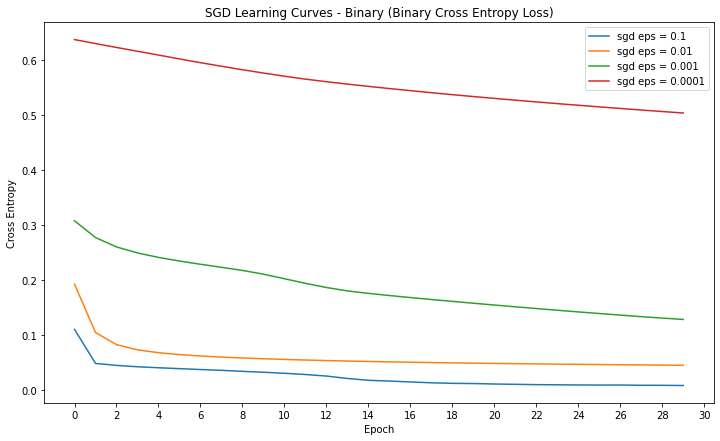

In [22]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

There is a clear picture here: the higher we set our learning rate, the faster the model converged to some minimum over the number of epochs that we ran our model for. 

**AUC:**<br>
To make more sense out of loss plot above, we look at how the model performed through an AUC score metric.

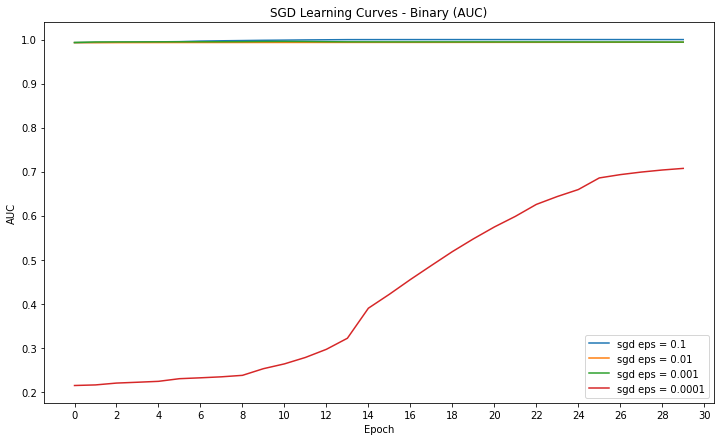

In [13]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

A similar behaviour to what we had for our loss plots is seen; the lowest learning rate performs the worst and is the slowest to converge to a good solution (whether it fully converges or not, we cannot tell from this plot as we only ran for 30 epochs), whereas the higher 3 learning rates performed almost perfectly.

We inspect the plots again below, removing `eps = 0.0001`, so that we can see the other learning rates' performances much more clearly.

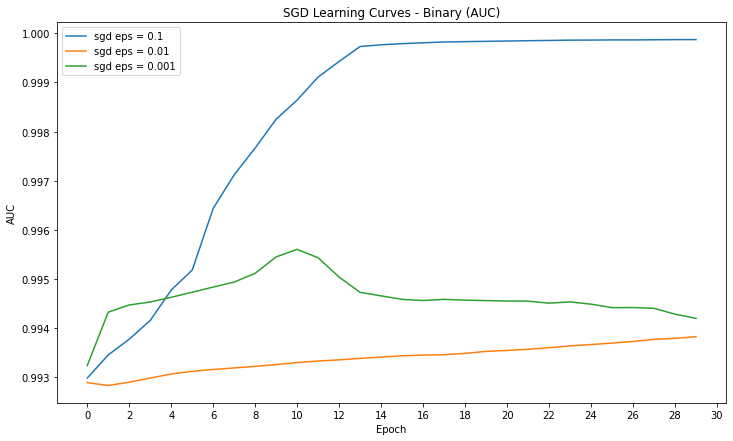

In [24]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


for count in range(1,len(epsilons)):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)].history['val_auc'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Something interesting is happening here. It seems as though the learning rate of 0.01 is not performing better (at least in terms of AUC), even though it was consistently at a lower binary crossentropy score. Though, interestingly, the curve for 0.001 learning rate seems to decrease after a while, possibly due to having overfit to the training data in comparison to the out-of-sample data we are assessing it on here. However, we still do see a clear outperformance by the learning rate of 0.1, though realistically, a difference between 1 and 0.993 may not really be that significant.

**I DONT KNOW WHY**

### Categorical Model

**Categorical Crossentropy Loss**<br>
Similarly to what we did above, we look at the learning curves, plotting categorical crossentropy loss for our multiclass model.

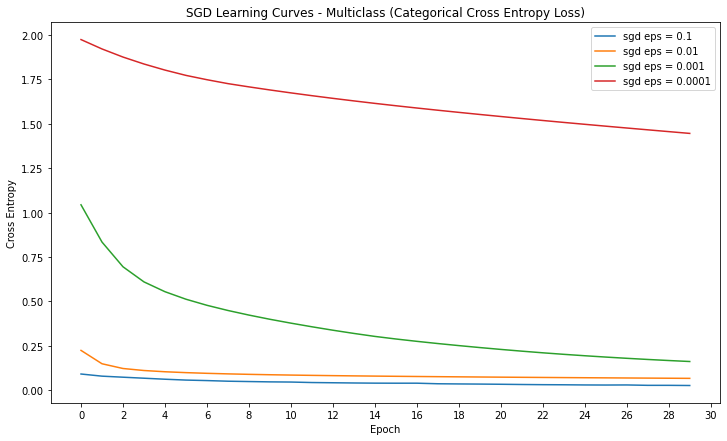

In [14]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

This is realistically the same image as we saw above for the binary model but with higher loss values throughout, which is entirely expected given that the dataset is the same and so it is not unreasonable to suspect that different attack categories lie on some shared manifold that coincides with the binary attacks in a lower dimension. However, having more categories to distinguish from, especially when some of them are less prevalent in the training data is naturally a more difficult problem and so the higher loss values are also expected.

**Categorical Accuracy**<br>
Again, we look at another measure to gain better understanding of what is shown to us by the loss function above. Here, we look at categorical accuracy.

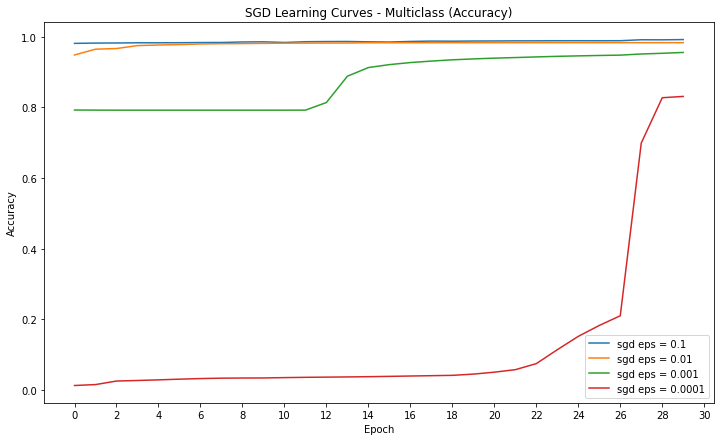

In [15]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Unsurprisingly, the same behaviour persists; very low values of learning rate seem to perform worse in classification. We remove the lowest value and plot again to enable clearer comparison since the higher two values perform so closely to one another as well.

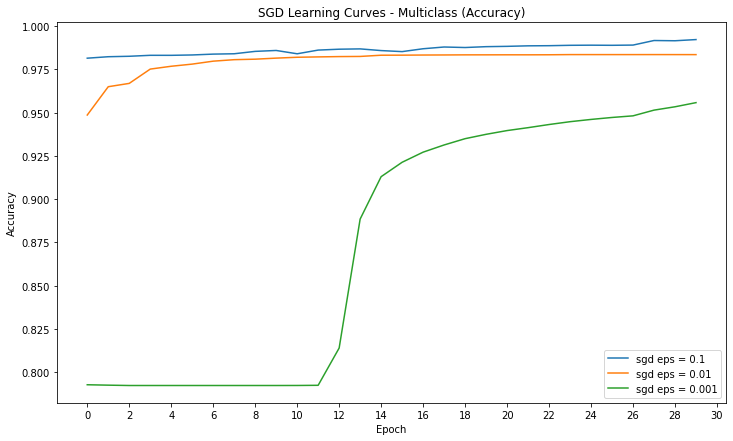

In [27]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(1,len(epsilons)):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)].history['val_accuracy'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Again, the learning rate of 0.1 performs best, but this time we do not have the scenario that we did with the binary case where a learning rate of 0.001 arguably performed better than a learning rate of 0.01. Instead, we see 0.001 learning rate stay stable at approximately 0.79 for 12 epochs (in our dataset this is the equivalent to the model only guessing dos attack to begin with as they make up 79.2% of all connections), before improving in detecting other types of connections (likely normal connections as normal + dos $\approx$ 98% of all connections. From this, we may suspect that only the optimizer with a learning rate of 0.1 is actually performing a somewhat good job.

### Confusion Matrices

### Binary Model

We take a look at the best performing binary model for completeness, but we will mostly focus on the categorical case so we need not make many comments here.

In [31]:
tf.random.set_seed(rseed)
sgd_pred = sgd_bin_model_1.predict(X_test)

In [32]:
sgd_pred_bin = sgd_pred
sgd_pred_bin[sgd_pred_bin>0.5]=1
sgd_pred_bin[sgd_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for SGD with learning rate 0.1')

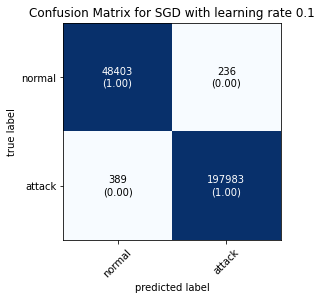

In [33]:
cmat_sgd = confusion_matrix(y_test_bin,sgd_pred)
cmat_sgd

plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for SGD with learning rate {}'.format(epsilons[0]))

Practically perfect performance, nothing much to comment on here as this was an easier problem for our model.

### Categorical Model

In [19]:
tf.random.set_seed(rseed)

for i in range(len(epsilons)):
    
    model = locals()['sgd_categ_model_{}'.format(i+1)]
    sgd_categ_pred = model.predict(X_test)
    locals()['sgd_categ_pred_{}'.format(i+1)] = sgd_categ_pred

In [20]:
categs

Index(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype='object')

In [53]:
for i in range(len(epsilons)):
    sgd_categ_pred = locals()['sgd_categ_pred_{}'.format(i+1)]
    
    cmat_categ_sgd = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(sgd_categ_pred,axis=1))
    
    locals()['cmat_categ_sgd_{}'.format(i+1)] = cmat_categ_sgd
    
del sgd_categ_pred

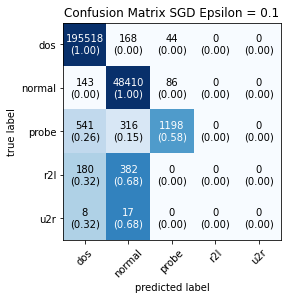

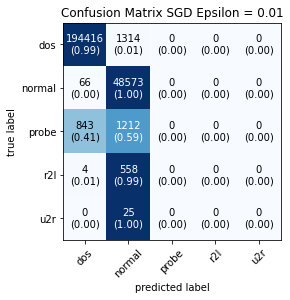

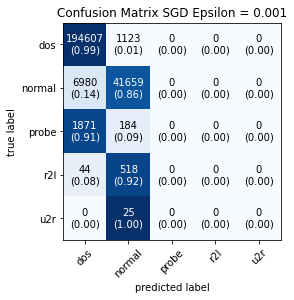

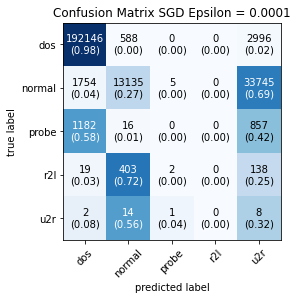

In [56]:
for i in range(len(epsilons)):
    sgd_categ_pred = locals()['cmat_categ_sgd_{}'.format(i+1)]
    plot_confusion_matrix(conf_mat = sgd_categ_pred,
                          show_normed = True,
                          class_names = categs)
    plt.title('Confusion Matrix {} Epsilon = {}'.format(opt.upper(),epsilons[i]))

There are a few interesting things to observe here. Firstly, we see that although the learning rates of 0.1 and 0.01 seemed to perform well (in terms of accuracy), this is largely due to predicting dos and normal connections correctly. A learning rate of 0.1 picks up about 58% of probe attacks but cannot identify any r2l or u2r connections, while a learning rate of 0.01 does not categorise any of these three categories. 

Secondly, when we look at the lowest learning rate of 0.0001, we see that our model is actually able to categorise some u2r attacks (though whether it is actually detecting them is debatable, as it also categorises a significant percentage of normal, probe, and r2l connections as u2r), whereas none of the other learning rates were able to do this. This could just be thec ase of u2r falling in some region outside of the local minima that our model tends towards, and so predictions of u2r may just disappear with time. This would be something to further investigate by tuning parameters such as dropout rate, but we do not attempt this here.

# OLD

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', metrics = ['accuracy']):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(num_classes, activation = 'softmax'))
    
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

Train binary and multiclass models for NAG, SGD, and SGD.

In [6]:
count = 1

start = time.time()

#5 learning rates equally spaced between 1/10,000 and 1/100
for eps in np.linspace(1/10000,1/100,5):
    
    eps = round(eps,5)
    #create the 3 optimizer with learning rate above
    sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
                                      momentum = 0.9,
                                      nesterov = False)

#     nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
#                                       momentum = 0.9, 
#                                       nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.SGD(learning_rate = eps)

    #fit same model architecture for each optimizer
    for opt in ['sgd']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #record model history fitting to binary training data with validation split
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = 30, batch_size = 10000)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
        
        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = 30, batch_size = 10000)
    
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
        del categ_model_temp
        del categ_history_temp
        print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to sgd optimizer with learning rate 0.0001----------
Epoch 1/30
5/5 [==============================] - 3s 256ms/step - loss: 0.5904 - auc: 0.1622 - val_loss: 0.5890 - val_auc: 0.1601
Epoch 2/30
5/5 [==============================] - 0s 96ms/step - loss: 0.5872 - auc: 0.1659 - val_loss: 0.5844 - val_auc: 0.1651
Epoch 3/30
5/5 [==============================] - 0s 98ms/step - loss: 0.5820 - auc: 0.1704 - val_loss: 0.5784 - val_auc: 0.1714
Epoch 4/30
5/5 [==============================] - 0s 98ms/step - loss: 0.5757 - auc: 0.1774 - val_loss: 0.5718 - val_auc: 0.1795
Epoch 5/30
5/5 [==============================] - 0s 97ms/step - loss: 0.5689 - auc: 0.1877 - val_loss: 0.5648 - val_auc: 0.1946
Epoch 6/30
5/5 [==============================] - 0s 77ms/step - loss: 0.5619 - auc: 0.2010 - val_loss: 0.5578 - val_auc: 0.2081
Epoch 7/30
5/5 [==============================] - 0s 79ms/step - loss: 0.5549 - auc: 0.2157 - val_loss: 0.5508 - val_auc: 0.2242
Epoch 8/30
5

In [7]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  109.172968 seconds


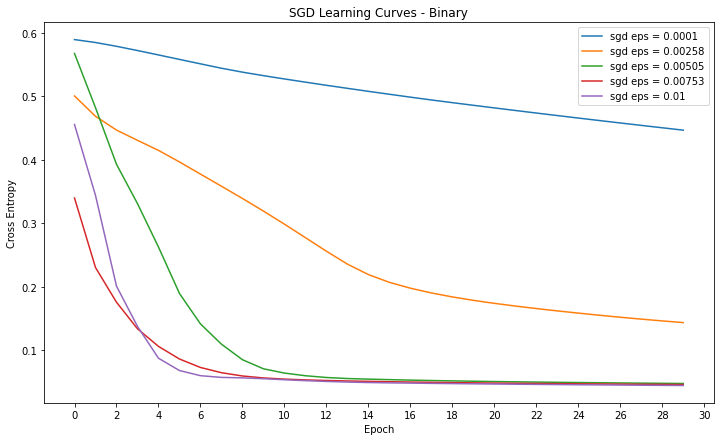

In [8]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_bin_history_1.history['val_loss'],label='sgd eps = 0.0001')
plt.plot(sgd_bin_history_2.history['val_loss'],label='sgd eps = 0.00258')
plt.plot(sgd_bin_history_3.history['val_loss'],label='sgd eps = 0.00505')
plt.plot(sgd_bin_history_4.history['val_loss'],label='sgd eps = 0.00753')
plt.plot(sgd_bin_history_5.history['val_loss'],label='sgd eps = 0.01')

plt.legend()
plt.show()

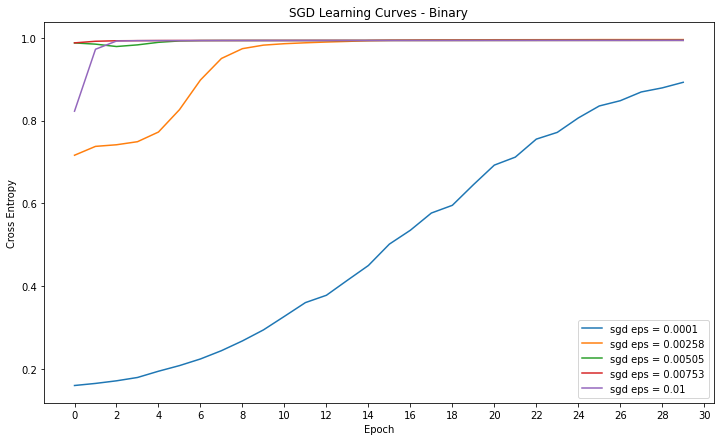

In [9]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_bin_history_1.history['val_auc'],label='sgd eps = 0.0001')
plt.plot(sgd_bin_history_2.history['val_auc'],label='sgd eps = 0.00258')
plt.plot(sgd_bin_history_3.history['val_auc'],label='sgd eps = 0.00505')
plt.plot(sgd_bin_history_4.history['val_auc'],label='sgd eps = 0.00753')
plt.plot(sgd_bin_history_5.history['val_auc'],label='sgd eps = 0.01')

plt.legend()
plt.show()

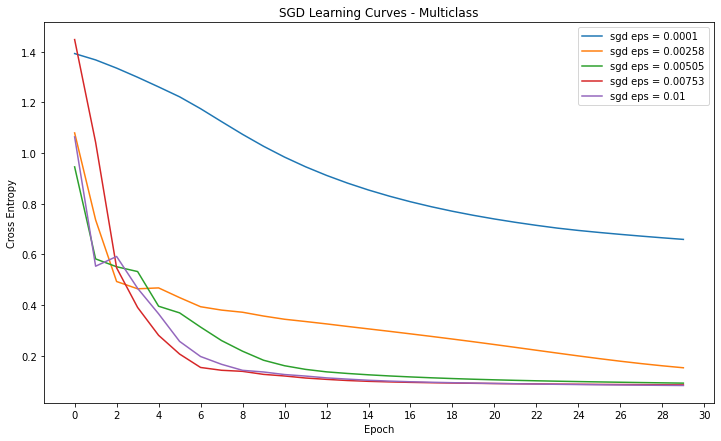

In [10]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_categ_history_1.history['val_loss'],label='sgd eps = 0.0001')
plt.plot(sgd_categ_history_2.history['val_loss'],label='sgd eps = 0.00258')
plt.plot(sgd_categ_history_3.history['val_loss'],label='sgd eps = 0.00505')
plt.plot(sgd_categ_history_4.history['val_loss'],label='sgd eps = 0.00753')
plt.plot(sgd_categ_history_5.history['val_loss'],label='sgd eps = 0.01')

plt.legend()
plt.show()

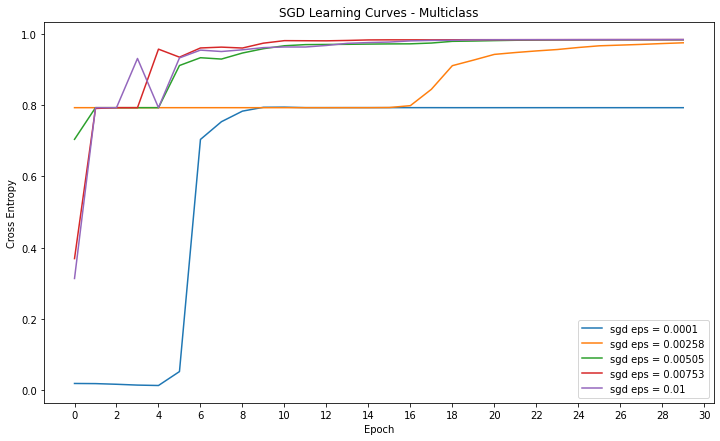

In [11]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_categ_history_1.history['val_accuracy'],label='sgd eps = 0.0001')
plt.plot(sgd_categ_history_2.history['val_accuracy'],label='sgd eps = 0.00258')
plt.plot(sgd_categ_history_3.history['val_accuracy'],label='sgd eps = 0.00505')
plt.plot(sgd_categ_history_4.history['val_accuracy'],label='sgd eps = 0.00753')
plt.plot(sgd_categ_history_5.history['val_accuracy'],label='sgd eps = 0.01')

plt.legend()
plt.show()

In [13]:
sgd_pred = sgd_bin_model_3.predict(X_test)

In [14]:
sgd_pred_bin = sgd_pred
sgd_pred_bin[sgd_pred_bin>0.5]=1
sgd_pred_bin[sgd_pred_bin<0.5]=0

In [15]:
from mlxtend.plotting import plot_confusion_matrix

In [16]:
import matplotlib

In [17]:
from sklearn.metrics import confusion_matrix

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

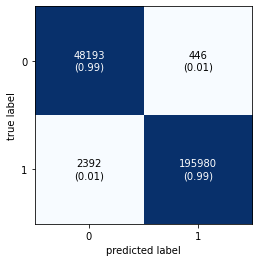

In [18]:
cmat_sgd = confusion_matrix(y_test_bin,sgd_pred)
cmat_sgd
plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True
)

In [19]:
sgd_categ_pred = sgd_categ_model_4.predict(X_test)

In [20]:
sgd_categ_pred

array([[9.8798394e-01, 3.1195774e-03, 4.6708388e-03, 4.0501249e-03,
        1.7554208e-04],
       [9.9783593e-01, 1.1966450e-03, 6.0433417e-04, 3.6070115e-04,
        2.4384983e-06],
       [1.1608812e-02, 9.8337644e-01, 4.1602342e-03, 4.2918252e-04,
        4.2525935e-04],
       ...,
       [9.9783593e-01, 1.1966444e-03, 6.0433417e-04, 3.6070077e-04,
        2.4384958e-06],
       [1.0004766e-01, 8.4036684e-01, 3.8859438e-02, 1.0967758e-02,
        9.7582666e-03],
       [9.9062026e-01, 1.6444534e-03, 3.7425747e-03, 3.8603549e-03,
        1.3243667e-04]], dtype=float32)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

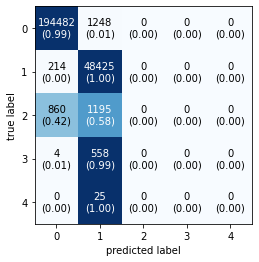

In [21]:
cmat_sgd = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(sgd_categ_pred,axis=1))

plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True
)